Best result: D 1 C = 16384 C_deg =  14 L =  0.0678260869565
Best result: D 2 C = 1048576 C_deg =  20 L =  0.0805797101449
Best result: D 3 C = 1048576 C_deg =  20 L =  0.219420289855
Best result: D 4 C = 1048576 C_deg =  20 L =  0.391884057971
C* =  16384


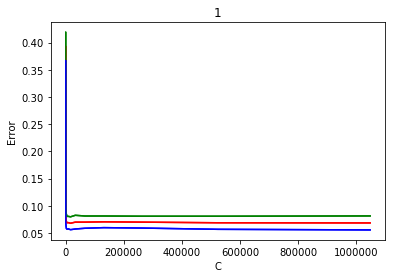

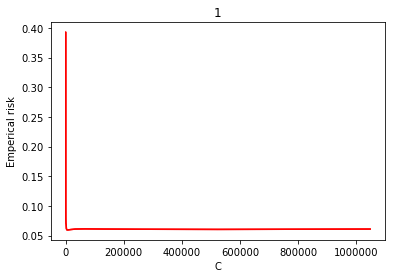

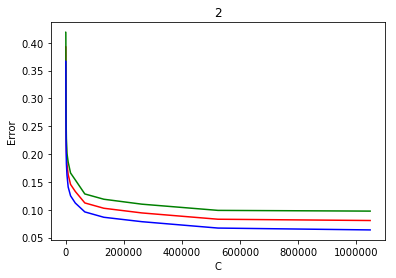

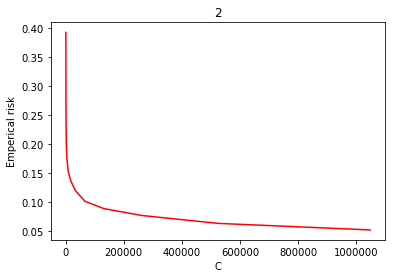

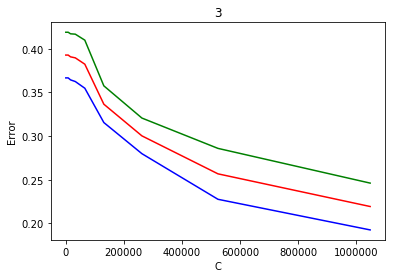

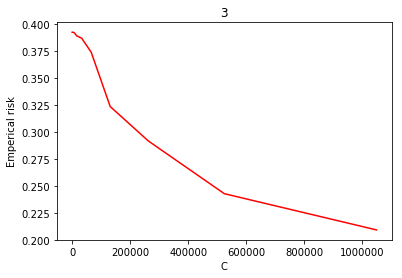

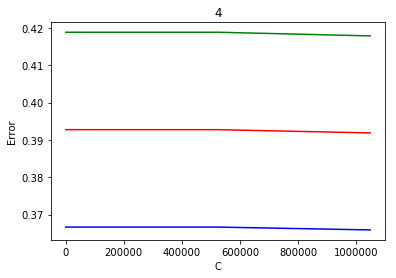

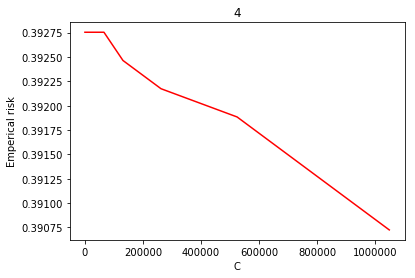

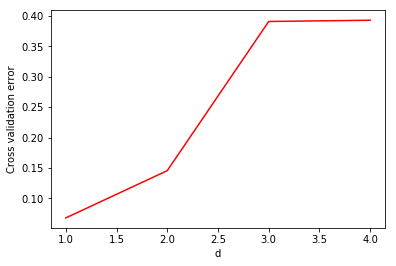

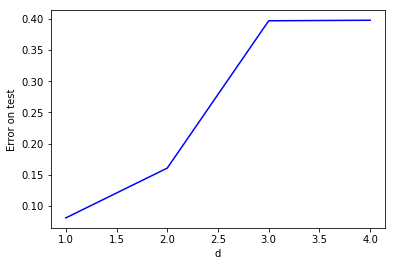

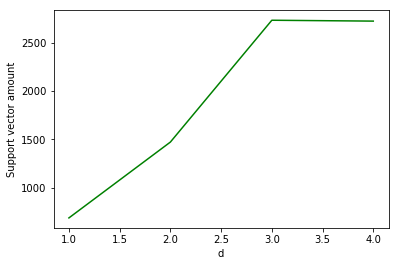

Cross validation error [0.06782608695652174, 0.14550724637681162, 0.3907246376811594, 0.3927536231884058]
Error on test [0.08079930495221546, 0.16072980017376196, 0.3970460469157255, 0.3979148566463944]
Support vector amount [688, 1473, 2734, 2725]


In [6]:
from svmutil import *
import csv
import math
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import subprocess

def convert_data_and_split(input_file_path, l_output_file_path,t_output_file_path, learn_size):
    with open(input_file_path) as input, open(l_output_file_path, 'w') as loutput,open(t_output_file_path, 'w') as toutput:
        reader = csv.reader(input, delimiter=',')
        lwriter = csv.writer(loutput, delimiter=' ',lineterminator = '\n')
        twriter = csv.writer(toutput, delimiter=' ',lineterminator = '\n')
        line_num = 0
        for input_row in reader:
        
            output_row = list()
            output_row.append(input_row[57]) # moving class value to the beginning
            for idx, attribute in enumerate(input_row[:-1]):
                if float(attribute) != 0:
                    output_row.append(str(idx + 1) + ":" + attribute)
            if line_num < learn_size:
                lwriter.writerow(output_row)
            else:
                twriter.writerow(output_row)
            line_num+=1

convert_data_and_split("spambase.data.shuffled.txt","spam_shuffled_learn.txt", "spam_shuffled_test.txt", 3450)
subprocess.call(['svm-scale.exe', '-l', '0', '-u', '1', '-s', 'save_params.txt', 'spam_shuffled_learn.txt', 
'>','spam_scaled_learn.txt'], shell=True) 
subprocess.call(['svm-scale.exe', '-r' ,'save_params.txt', 'spam_shuffled_test.txt', 
'>','spam_scaled_test.txt'], shell=True)


def readXY(input_file_path):
    with open(input_file_path) as input:
        reader = csv.reader(input, delimiter=',')
        X = []
        y = []
        for input_row in reader:
            y.append(int(input_row[57])) 
            x=[]
            for idx, attribute in enumerate(input_row[:-1]):
                #if float(attribute) != 0:
                x.append(float(attribute))
            X.append(x)
    return X,y

def train_kfold(y,x,c_deg_start, c_deg_end,d,k):
    minL = 1000000
    goofD=1
    goodCDeg=0
    results = []
    for c_deg in xrange(c_deg_start,c_deg_end):
        c = 2**c_deg
        L,acc,dev,emp = k_fold(k,x,y,d,c)
        if(L<minL):
            minL = L
            goodCDeg = c_deg
            goofD = d
        #print "Deg=",d,"C=",c,"C_deg=",c_deg,"Ld=",L,"Accuracy=",acc,"Deviation=",dev,"Emperical risk=",emp
        results.append([d,c,c_deg,L,acc,dev,emp])
    return goodCDeg,goofD,minL,results

def k_fold(k,x,y,d,c):
    mk =len(y)/k
    error = 0
    acc = 0
    errors = []
    emp_error = 0
    for i in range(k):
        validationX = x[i*mk:(i+1)*mk]
        validationY = y[i*mk:(i+1)*mk]
        trainX = x[:i*mk] +x[(i+1)*mk:]
        trainY = y[:i*mk] +y[(i+1)*mk:]
        model = svm_train(trainY,trainX, "-t 1 -d "+str(d)+" -c "+ str(c))
        p_label, p_acc, p_val = svm_predict(validationY,validationX,model,"-q")
        error += p_acc[1]
        errors.append(p_acc[1])
        acc += p_acc[0]
    model = svm_train(y,x, "-t 1 -d "+str(d)+" -c "+ str(c))
    p_label, p_acc, p_val = svm_predict(y,x,model,"-q")
    avg_err = error/k
    deviation = math.sqrt(sum([(i-avg_err)**2 for i in errors])/k)
    return avg_err, acc/k,deviation,p_acc[1]

def draw_plot_from_data(data):
    #x_axis = [i for i in xrange(-20,21)]
    x_axis = [i[1] for i in data]
    y_axis = [i[3] for i in data]
    y_axis2 = [i[3]+i[5] for i in data]
    y_axis3 = [i[3]-i[5] for i in data]
    plt.plot(x_axis,y_axis,"r")
    plt.plot(x_axis,y_axis2,"g")
    plt.plot(x_axis,y_axis3,"b")
    plt.xlabel("C")
    plt.ylabel("Error")
    plt.title(data[0][0])
    
def draw_plot_from_data_emp_risk(data):
    #x_axis = [i for i in xrange(-20,21)]
    x_axis = [i[1] for i in data]
    y_axis = [i[6] for i in data]
    plt.plot(x_axis,y_axis,"r")
    plt.xlabel("C")
    plt.ylabel("Emperical risk")
    plt.title(data[0][0])

#X,y =  readXY("learn_input.txt")
y,X = svm_read_problem("spam_scaled_learn.txt")

k = 20
fig_num = 1
L_min = 1000000
bestCDeg = 1
bestD = 1
for d in xrange(1,5):
    goodCDeg,goodD,L,results = train_kfold(y,X,-k,k+1,d,10)
    print "Best result: D",d,"C =",2**goodCDeg,"C_deg = ",goodCDeg,"L = ",L
    plt.figure(fig_num)
    fig_num+=1
    draw_plot_from_data(results)
    plt.figure(fig_num)
    fig_num+=1
    draw_plot_from_data_emp_risk(results)
    #print results
    if(L_min>L):
        L_min = L
        bestCDeg = goodCDeg
        bestD = goodD

print "C* = ",(2**bestCDeg)
        
crossValErr = []
testErr = []
svAmount = []
#Xt,yt =  readXY("test_input.txt")
yt,Xt = svm_read_problem("spam_scaled_test.txt")

for d in xrange(1,5):
    goodCDeg,goofD,L,results = train_kfold(y,X,bestCDeg,bestCDeg+1,d,10)
    crossValErr.append(results[0][3])
    model = svm_train(y,X, "-t 1 -d "+str(d)+" -c "+ str(2**bestCDeg))
    p_label, p_acc, p_val = svm_predict(yt,Xt,model,"-q")
    testErr.append(p_acc[1])
    svAmount.append(len(model.get_SV()))
    
x_axis = [i for i in xrange(1,5)]
plt.figure(fig_num)
fig_num+=1
plt.plot(x_axis,crossValErr,"r")
plt.xlabel("d")
plt.ylabel("Cross validation error")

plt.figure(fig_num)
fig_num+=1
plt.plot(x_axis,testErr,"b")
plt.xlabel("d")
plt.ylabel("Error on test")

plt.figure(fig_num)
fig_num+=1
plt.plot(x_axis,svAmount,"g")
plt.xlabel("d")
plt.ylabel("Support vector amount")

plt.show()

print "Cross validation error",crossValErr
print "Error on test",testErr
print "Support vector amount",svAmount
